# Twitter Sentiment Analysis

## Overview
This project is aimed at building and evaluating machine learning models for sentiment analysis on Twitter data. Sentiment analysis involves classifying text data into different sentiment categories such as positive, negative, or neutral. In this project, we collect and preprocess Twitter data, including cleaning the text, removing noise, and transforming it into a format suitable for machine learning algorithms.

Once the data preprocessing is complete, we train several machine learning models on the preprocessed data to predict the sentiment of tweets. Some of the models considered in this project include Naive Bayes, Logistic Regression, Random Forest, AdaBoost, XGBoost, and K-Nearest Neighbors. We use techniques such as pipeline construction and hyperparameter tuning with GridSearchCV to optimize the performance of these models.

After training and evaluating individual models, we explore ensemble learning techniques such as Voting Classifier, which combines predictions from multiple base models to make a final prediction. We experiment with different combinations of base models to find the ensemble that yields the best performance in terms of accuracy and other evaluation metrics.

Throughout the project, we focus on best practices in machine learning, including data preprocessing, model selection, hyperparameter tuning, and evaluation. The ultimate goal is to develop an accurate and reliable sentiment analysis model that can effectively analyze Twitter data and provide valuable insights into public opinion and sentiment trends.

## Business Problem
In today's digital age, companies and brands are increasingly leveraging social media platforms such as Twitter to connect with their audience, build brand loyalty, and monitor public sentiment. However, analyzing the vast amount of user-generated content on Twitter to gauge public opinion manually can be time-consuming and inefficient. Therefore, the business problem we aim to address with this project is the need for an automated sentiment analysis solution that accurately classifies tweets as either positive or negative. By automating the sentiment analysis process, companies can gain valuable insights into customer perceptions, identify emerging trends, and tailor their marketing strategies to better resonate with their target audience.

The stakeholders who could benefit from this project include marketing professionals, brand managers, social media analysts, and business decision-makers. Marketing professionals can use the sentiment analysis tool to gauge the effectiveness of their marketing campaigns in real-time and adjust their strategies accordingly. Brand managers can monitor brand perception and identify potential issues or crises before they escalate. Social media analysts can track public sentiment trends over time and identify key influencers or opinion leaders within their industry. Business decision-makers can use the insights gained from sentiment analysis to make informed decisions about product development, customer service improvements, and crisis management strategies. Ultimately, this project aims to provide a valuable tool for stakeholders to better understand and respond to public sentiment on Twitter, thereby enhancing brand reputation and driving business success.


## Data Understanding

The dataset used in this project was sourced from [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions). It comprises tweets about various brands and products, with contributors tasked to evaluate whether each tweet expresses a positive, negative, or neutral emotion towards a specific brand or product. The dataset contains a total of 9093 rows of data. For each tweet, the target brand or product of the expressed emotion is identified. Exploratory analysis of the dataset reveals that it provides a rich source of information for sentiment analysis, as it captures real-time opinions and emotions expressed by users on Twitter regarding different brands and products.

### EDA

In this Jupyter notebook, we embark on a journey to analyze sentiment in tweets related to Apple and Google products. Our goals are to understand the dataset's structure, clean and preprocess the data, and prepare it for a machine learning model that predicts sentiment based on tweet content. Let's start by loading the dataset and performing an exploratory data analysis (EDA).


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Natural Language Toolkit for text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')  # Download NLTK resources if not already present
nltk.download('stopwords')

# Regular Expressions for pattern matching
import re

# String module for string operations
import string

# Counter for counting occurrences of elements
from collections import Counter

# Machine learning
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics and Visualization
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Imbalanced-learn for dealing with class imbalance
from imblearn.over_sampling import RandomOverSampler

# Other Utilities
from itertools import combinations

# Set up warning suppression
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load and Explore the Dataset
First, we load the dataset to understand its basic structure, including the number of entries, columns, and types of data it contains. This initial exploration is crucial for planning our preprocessing steps.

The dataset contains three columns:
- `tweet_text`: The text of the tweet.
- `emotion_in_tweet_is_directed_at`: The product or brand the tweet is directed at (e.g., iPhone, iPad, Google).
- `is_there_an_emotion_directed_at_a_brand_or_product`: The sentiment of the tweet (e.g., Positive emotion, Negative emotion).



In [2]:
# Define the path to the CSV file containing the dataset
data_path = 'data/judge-1377884607_tweet_product_company.csv'

# Read the dataset into a pandas DataFrame using pd.read_csv()
# We specify the encoding as 'ISO-8859-1' to handle potential encoding issues
tweets_df = pd.read_csv(data_path, encoding='ISO-8859-1')

# Print the shape of the dataset (number of rows and columns)
print("Dataset shape:", tweets_df.shape)

# Print the data types of each column in the dataset
print("Data types:\n", tweets_df.dtypes)

# Display the first few rows of the DataFrame using .head()
tweets_df.head()

Dataset shape: (9093, 3)
Data types:
 tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Missing Values Analysis
Identifying and handling missing values is crucial since they can significantly impact the performance of our model.

The dataset contains missing values, primarily in the `emotion_in_tweet_is_directed_at` column, with a smaller number in the `tweet_text` column. Since our primary focus is sentiment analysis based on the tweet text, we'll proceed by dropping rows where the tweet text is missing. The `emotion_in_tweet_is_directed_at column` can be ignored for our current purpose, as we are focusing on sentiment, not the specific product mentioned.

We will just drop the single row that is missing a tweet because this will not help our model.

In [5]:
# Check for missing values in each column of the DataFrame using .isnull().sum()
missing_values = tweets_df.isnull().sum()

# Print the number of missing values in each column
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [6]:
# Remove rows with null values in the 'tweet_text' column in the original DataFrame
tweets_df = tweets_df.dropna(subset=['tweet_text'])

### Sentiment Distribution
Understanding the balance between different sentiment classes helps us gauge the dataset's bias towards certain sentiments. This is important for selecting appropriate modeling and resampling techniques. 

The `is_there_an_emotion_directed_at_a_brand_or_product` column has four unique labels:

- Negative emotion
- Positive emotion
- No emotion toward brand or product
- I can't tell

For the sentiment analysis model, we'll focus on positive and negative emotions. We'll treat "No emotion toward brand or product" and "I can't tell" as neutral or unknown sentiments, which might be excluded from the training to focus the model on distinguishing clearly between positive and negative sentiments.

We have 2,978 positive and 570 negative sentiment tweets. This imbalance in the dataset could influence the performance of our model, making it potentially biased towards predicting positive sentiments. We'll need to keep this in mind during the modeling phase, possibly using techniques like oversampling the minority class, undersampling the majority class, or adjusting the class weights in the model training process to address this imbalance.

In [7]:
sentiment_distribution = tweets_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
print("Sentiment distribution:\n", sentiment_distribution)

Sentiment distribution:
 No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


### Text Length Analysis
Analyzing the length of tweets can reveal insights about the dataset's variability. To address the variability in text length observed in the dataset, we can leverage techniques such as text cleaning and TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. Through text cleaning, we can remove punctuation, URLs, special characters, mentions, hashtags, and other non-essential elements from the tweets, resulting in a more standardized format. This process helps to ensure that the content of the tweets remains intact while eliminating unnecessary variations in text structure. Additionally, TF-IDF vectorization transforms each tweet into a fixed-length numerical vector representation based on the importance of each term relative to the entire dataset. This technique allows us to capture the significance of words in each tweet while normalizing the representation regardless of the absolute length of the tweet. 

These preprocessing steps are particularly useful given the insights gained from analyzing the text length distribution, where the mean length of tweets is approximately 105 characters with a standard deviation of around 27 characters. By employing these methods, we can effectively manage the variability in text length and facilitate consistent analysis across the dataset for tasks such as sentiment classification.


In [8]:
tweets_df['text_length'] = tweets_df['tweet_text'].apply(lambda x: len(str(x)))
tweets_df['text_length'].describe()

count    9092.000000
mean      104.962275
std        27.187640
min        11.000000
25%        86.000000
50%       109.000000
75%       126.000000
max       178.000000
Name: text_length, dtype: float64

### Frequent Words Analysis
The frequent words analysis provides insights into the most commonly occurring words in the dataset, which can help us understand common themes and refine our list of stopwords. In the results provided, we observe that certain words such as **'#'**, **'sxsw'**, **'@'**, **'mention'**, **'.'**, **'the'**, **'link'**, **'}'**, **'{'**, **'to'**, **','**, **'at'**, **'rt'**, **';'**, **'&'**, **'google'**, **'for'**, **'ipad'**, **'!'**, and **'a'** appear frequently. However, many of these words are not informative in terms of sentiment analysis or topic classification. For example, symbols like **'#'**, **'@'**, **'.'**, **','**, **';'**, **'&'**, **'{'**, **'}'**, **'!'**, and **'rt'** are not indicative of sentiment and may be artifacts of social media platforms or text formatting. Similarly, common English stopwords like **'the'**, **'to'**, **'for'**, and **'a'** typically carry little sentiment value and can be safely removed to improve the accuracy of our models. Therefore, these frequent words will need to be removed from the text data before further analysis to focus on more meaningful terms that contribute to sentiment or topic identification.


In [9]:
# Concatenate all tweet texts into a single string, convert to lowercase
all_words = ' '.join(tweets_df['tweet_text'].dropna()).lower()

# Tokenize the concatenated string into individual words
all_words_tokenized = word_tokenize(all_words)

# Count the occurrences of each word and select the 20 most common words
word_counts = Counter(all_words_tokenized)
most_common_words = word_counts.most_common(20)

[('#', 15875),
 ('sxsw', 9516),
 ('@', 7194),
 ('mention', 7124),
 ('.', 5506),
 ('the', 4424),
 ('link', 4313),
 ('}', 4298),
 ('{', 4296),
 ('to', 3586),
 (',', 3533),
 ('at', 3102),
 ('rt', 2962),
 (';', 2800),
 ('&', 2707),
 ('google', 2595),
 ('for', 2545),
 ('ipad', 2446),
 ('!', 2398),
 ('a', 2312)]

### Special Characters and URLs Analysis
Examining **special characters** and **URLs** in tweets is essential for preprocessing text data before sentiment analysis. **Special characters** such as hashtags (**'#'**), mentions (**'@'**), punctuation marks (**'.'**), and symbols (**'&'**, **'-'**, etc.) are often used in tweets for formatting, emphasis, or conveying information. While some of these characters may carry sentiment value (e.g., emojis), others are merely artifacts of social media communication and do not contribute meaningfully to sentiment analysis. Similarly, **URLs**, which often appear in tweets as hyperlinks to external content, typically do not convey sentiment on their own and may introduce noise into the analysis. Therefore, removing these **special characters** and **URLs** can help streamline the text preprocessing pipeline, reducing complexity and potentially improving model performance by focusing on the essential content of the tweets. Additionally, removing **URLs** can help mitigate privacy and security concerns associated with accessing external web resources during analysis.


In [10]:
# Extract special characters from each tweet using regular expressions
special_chars = tweets_df['tweet_text'].apply(lambda x: re.findall(r'[^\w\s]', str(x)))

# Count the occurrences of each special character
special_chars_counts = Counter([item for sublist in special_chars for item in sublist])

# Print the 10 most common special characters and their counts
print("Special characters counts:", special_chars_counts.most_common(10))

# Count the number of URLs in the tweets using regular expressions
urls_counts = tweets_df['tweet_text'].apply(lambda x: len(re.findall(r"http\S+|www\S+|https\S+", str(x)))).sum()

# Print the total number of URLs found in the tweets
print("Number of URLs:", urls_counts)


Special characters counts: [('#', 15875), ('.', 8382), ('@', 7194), ('}', 4298), ('{', 4296), (',', 3558), ("'", 2903), (';', 2800), ('&', 2707), ('-', 2438)]
Number of URLs: 44


## Preprocessing Before Train/Test Split


### Encoding Sentiment Labels
In the process of preparing our data for modeling, it's essential to convert the sentiment labels from their textual representation into a numerical format that our machine learning algorithms can understand. To achieve this, we utilize a mapping dictionary called sentiment_mapping, where we assign the value 1 to represent positive emotions and the value 0 to represent negative emotions. This encoding allows us to transform the sentiment labels from 'Positive emotion' and 'Negative emotion' to their corresponding numerical equivalents. By applying this mapping using the map() function to the column containing the sentiment labels in our DataFrame (tweets_df), we create a new column named sentiment_label, which now holds the encoded numerical values. This encoding step is crucial as it facilitates the subsequent modeling process, enabling our algorithms to effectively learn and make predictions based on the sentiment labels.

In [11]:
# Define a mapping dictionary to encode sentiment labels into numerical format
sentiment_mapping = {
    'Positive emotion': 1,  # Assign value 1 to represent positive emotion
    'Negative emotion': 0   # Assign value 0 to represent negative emotion
}

# Map sentiment labels to their corresponding numerical values using the defined mapping
# The 'is_there_an_emotion_directed_at_a_brand_or_product' column contains the sentiment labels
# The result is stored in a new column named 'sentiment_label'
tweets_df['sentiment_label'] = tweets_df['is_there_an_emotion_directed_at_a_brand_or_product'].map(sentiment_mapping)

In [12]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          9092 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object 
 3   text_length                                         9092 non-null   int64  
 4   sentiment_label                                     3548 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 426.2+ KB


### Handling Missing Values
After encoding sentiment labels into numerical format, some rows in the dataset may still have missing sentiment labels due to unknown or no emotion expressed in the tweets. To ensure the integrity of our model training, it's essential to handle these missing values appropriately. In this case, we choose to remove rows with missing sentiment labels or cleaned tweets. By dropping these rows, we focus our analysis solely on tweets with clearly defined positive or negative emotions. This approach helps prevent potential misinterpretation of missing sentiment labels during model training, which could otherwise lead to biased or inaccurate predictions. Consequently, by retaining only the tweets with explicit sentiment labels, we streamline the dataset and enhance the quality of our sentiment analysis task.

In [13]:
# Dropping rows with any missing sentiment labels or cleaned tweets
tweets_df = tweets_df.dropna(subset=['sentiment_label'])
tweets_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 9088
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          3548 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3191 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  3548 non-null   object 
 3   text_length                                         3548 non-null   int64  
 4   sentiment_label                                     3548 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 166.3+ KB


## Train/Test Split
Before training our model, we'll split the dataset into training and testing sets. This allows us to train our model on one subset of the data and then test its performance on unseen data, providing a better evaluation of its real-world performance. We will allocate 20% of the data for testing and 80% for training. The split maintains the distribution of sentiment labels to prevent bias. A random seed of 42 ensures reproducibility across runs.


In [14]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tweets_df['tweet_text'],
    tweets_df['sentiment_label'],
    stratify=tweets_df['sentiment_label'],
    test_size=0.2, 
    random_state=42
)


### Cleaning the Text Data
The next step in our preprocessing is to clean the text data. In this section, the text data undergoes preprocessing to ensure its suitability for sentiment analysis. The clean_tweet function is defined to perform several cleaning tasks. First, it converts all text to lowercase to standardize the case. Then, it removes punctuation, URLs, special characters, mentions, hashtags, and the term "RT" (typically used for retweets). Tokenization breaks the text into individual words, followed by the removal of stopwords and unnecessary whitespace. Lemmatization is applied to reduce words to their base forms. Finally, numeric characters are removed, and the cleaned tokens are rejoined into a string format. This cleaning process helps to eliminate noise and focus on the essential content of the tweets, enhancing the effectiveness of sentiment analysis. The cleaned text data is then applied to both the training and testing sets to prepare them for further processing and model training.


In [15]:
#
def clean_tweet(tweet):
   # Lowercase the text
    tweet = tweet.lower()
    
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    
    # Remove special characters
    tweet = re.sub(r'[^\w\s]', '', tweet)
        
    # Remove the word link
    tweet = re.sub(r'\blink\b', ' ', tweet)
    
     # Remove mentions
    tweet = re.sub(r'@\w+\b', ' ', tweet) 
    
    # Remove the word mention
    tweet = re.sub(r'\bmention\b', ' ', tweet)

    # Remove sxsw
    tweet = re.sub(r'\bsxsw\b', ' ', tweet)
    
     # Remove the word "sxsw" from concatenated words
    tweet = re.sub(r'(?<=\S)sxsw(?=\S)', '', tweet)

    # Remove hashtags
    tweet = re.sub(r'#\w+', ' ', tweet)
    
    # Remove "RT"
    tweet = re.sub(r'\brt\b', ' ', tweet, flags=re.IGNORECASE)
    
    # Tokenization
    tokens = word_tokenize(tweet)
    
     # Remove stopwords and unnecessary white spaces
    stop_words = set(stopwords.words('english'))
    tokens = [word.strip() for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove numeric characters
    tokens = [word for word in tokens if not word.isdigit()]
    
    # Join tokens back into a string
    clean_tweet = ' '.join(tokens).strip()
    
    return clean_tweet


X_train = X_train.apply(clean_tweet)
X_test = X_test.apply(clean_tweet)

7003        someone buy ipad v1 wait line get v2 tomorrow
8981    think effing hubby line ipad someone point tow...
7351    smart company rumor apple opening temporary st...
7483                   google map mobile look awesomesxsw
1642        wishing excellent day today ive got ipad envy
Name: tweet_text, dtype: object

In [16]:
#Confirming all special characters and URLS are removed from the training set.
special_chars = X_train.apply(lambda x: re.findall(r'[^\w\s]', str(x)))
special_chars_counts = Counter([item for sublist in special_chars for item in sublist])
print("Special characters counts:", special_chars_counts.most_common(10))

#URLs
urls_counts = X_train.apply(lambda x: len(re.findall(r"http\S+|www\S+|https\S+", str(x)))).sum()
print("Number of URLs:", urls_counts)


Special characters counts: []
Number of URLs: 0


In [17]:
#Confirming all special characters and URLS are removed from the test set.
special_chars = X_test.apply(lambda x: re.findall(r'[^\w\s]', str(x)))
special_chars_counts = Counter([item for sublist in special_chars for item in sublist])
print("Special characters counts:", special_chars_counts.most_common(10))

#URLs
urls_counts = X_test.apply(lambda x: len(re.findall(r"http\S+|www\S+|https\S+", str(x)))).sum()
print("Number of URLs:", urls_counts)


Special characters counts: []
Number of URLs: 0


In [18]:
#Checking most frequent words in the training set. This looks good.
all_words = ' '.join(X_train.dropna()).lower()
all_words_tokenized = word_tokenize(all_words)

word_counts = Counter(all_words_tokenized)
word_counts.most_common(20)


[('ipad', 941),
 ('apple', 775),
 ('google', 673),
 ('iphone', 531),
 ('store', 473),
 ('app', 361),
 ('new', 327),
 ('austin', 245),
 ('popup', 186),
 ('android', 181),
 ('ipad2', 178),
 ('launch', 159),
 ('get', 155),
 ('amp', 155),
 ('one', 138),
 ('time', 132),
 ('like', 129),
 ('line', 128),
 ('social', 125),
 ('circle', 120)]

In [19]:
#Checking most frequent words in the test set. This looks good.
all_words = ' '.join(X_test.dropna()).lower()
all_words_tokenized = word_tokenize(all_words)

word_counts = Counter(all_words_tokenized)
word_counts.most_common(20)


[('ipad', 223),
 ('apple', 210),
 ('google', 159),
 ('iphone', 144),
 ('store', 121),
 ('app', 90),
 ('new', 75),
 ('austin', 71),
 ('get', 51),
 ('popup', 47),
 ('ipad2', 42),
 ('android', 41),
 ('amp', 40),
 ('launch', 36),
 ('day', 33),
 ('one', 33),
 ('line', 33),
 ('im', 32),
 ('party', 30),
 ('social', 29)]

### Text Vectorization (TF-IDF)
In the text vectorization step, we convert the cleaned text data into a numerical format suitable for machine learning models using TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF reflects the importance of each word in a document relative to a collection of documents, allowing us to weigh terms accordingly. In the provided code, we first define a TF-IDF vectorizer with parameters for stopwords removal and maximum features to limit the dimensionality of the vectorized data. Next, we fit and transform the training data to create TF-IDF matrices, both for the training and test sets, ensuring consistency in data representation. Finally, we apply normalization to the TF-IDF matrices using 'l2' normalization to scale the data, which can improve model performance. Overall, this process enables us to represent text data numerically while preserving the inherent semantic information, facilitating effective sentiment analysis or classification tasks.

In [20]:
# Define the TF-IDF vectorizer with stopwords removal and maximum features
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=10000)

# Fit and transform the training data
X_train_tfidf_un = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted TF-IDF vectorizer
X_test_tfidf_un = tfidf_vectorizer.transform(X_test)

# Normalize TF-IDF matrices
tfidf_transformer = TfidfTransformer(norm='l2')  # 'l2' normalization
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tfidf_un)
X_test_tfidf = tfidf_transformer.transform(X_test_tfidf_un)

### Handling Class Imbalance
To tackle the class imbalance observed in the sentiment labels, we employ random oversampling using the RandomOverSampler technique. This method involves randomly duplicating instances from the minority class (in this case, negative sentiment) to balance the class distribution. By increasing the representation of the minority class, we aim to prevent our model from becoming biased towards the majority class (positive sentiment), thereby improving its ability to generalize to unseen data and make accurate predictions.

In [21]:
#Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

#Resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

# Check the balance of the resampled data
resampled_balance = pd.Series(y_train_resampled).value_counts()

X_train_resampled.shape, resampled_balance

((4764, 5218),
 0.0    2382
 1.0    2382
 Name: sentiment_label, dtype: int64)

## Modeling
### Baseline Models
In this code snippet, we're evaluating the performance of several machine learning models for sentiment analysis. The models include Multinomial Naive Bayes, Logistic Regression, Random Forest, AdaBoost, XGBoost, and K-Nearest Neighbors. These models are implemented using default settings, without any hyperparameter tuning, to provide a baseline assessment of their performance. The evaluation is conducted using cross-validation, splitting the training data into multiple subsets for training and validation. The results, displayed in a DataFrame, show the mean accuracy scores across different cross-validation folds for each model. While Random Forest demonstrates the highest mean accuracy (97.40%), it's noteworthy that there are indications of slight overfitting, particularly evident in models like Multinomial Naive Bayes and Logistic Regression. This overfitting was expected, given the class imbalance in the dataset, where oversampling was employed to mitigate bias towards the majority class. These results serve as a starting point for model selection and further optimization to improve generalization performance.

In [22]:

# List to keep track of model performance
model_performance = []

# Function to evaluate a model and add its performance to our list
def evaluate_model(model, model_name, X, y, cv=5):
    scores = cross_validate(model, X, y, cv=cv, scoring='accuracy', return_train_score = True)
    model_performance.append({
        'Model': model_name,
        'CV Train Mean': round(np.mean(scores['train_score']),4),
        'CV Test Mean': round(np.mean(scores['test_score']),4),
        'CV Test Std': round(np.std(scores['test_score']),4)
    })


# Define pipelines for different models
nb_pipeline = Pipeline([('clf', MultinomialNB())])
lr_pipeline = Pipeline([('clf', LogisticRegression(random_state=42))])
rf_pipeline = Pipeline([('clf', RandomForestClassifier(random_state=42))])
ada_pipeline = Pipeline([('clf', AdaBoostClassifier(random_state=42))])
xgb_pipeline = Pipeline([('clf', XGBClassifier(random_state=42))])
knn_pipeline = Pipeline([('clf', KNeighborsClassifier())])

# Evaluate models
evaluate_model(nb_pipeline, 'Multinomial Naive Bayes', X_train_resampled, y_train_resampled)
evaluate_model(lr_pipeline, 'Logistic Regression', X_train_resampled, y_train_resampled)
evaluate_model(rf_pipeline, 'Random Forest', X_train_resampled, y_train_resampled)
evaluate_model(ada_pipeline, 'AdaBoost', X_train_resampled, y_train_resampled)
evaluate_model(xgb_pipeline, 'XGBoost', X_train_resampled, y_train_resampled)
evaluate_model(knn_pipeline, 'K-Nearest Neighbors', X_train_resampled, y_train_resampled)


# Convert the performance list to a DataFrame
performance_df = pd.DataFrame(model_performance)

# Sort the DataFrame by 'CV Test Accuracy Mean'
sorted_performance_df = performance_df.sort_values(by='CV Test Mean', ascending=False)

# Display the performance DataFrame
print(sorted_performance_df)

                     Model  CV Train Mean  CV Test Mean  CV Test Std
2            Random Forest         0.9988        0.9740       0.0040
1      Logistic Regression         0.9837        0.9509       0.0076
0  Multinomial Naive Bayes         0.9727        0.9215       0.0095
4                  XGBoost         0.9622        0.8969       0.0058
5      K-Nearest Neighbors         0.9102        0.8587       0.0139
3                 AdaBoost         0.7803        0.7550       0.0061


### Hyperparameter Tuning with GridSearchCV
n the next step of our analysis, we will employ GridSearchCV to perform hyperparameter tuning for each of our machine learning models. GridSearchCV systematically searches through a predefined grid of hyperparameters and selects the combination that yields the best performance based on a specified evaluation metric. By tuning hyperparameters such as regularization strength, tree depth, and learning rate, we aim to optimize the models' performance and enhance their ability to generalize to unseen data. This process allows us to explore a wider range of model configurations and fine-tune them to achieve better accuracy and robustness in sentiment analysis.


#### Random Forest
After performing hyperparameter tuning using GridSearchCV for the Random Forest model, we obtained the best set of parameters as follows: 'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, and 'n_estimators': 500. The best mean cross-validated accuracy achieved with these parameters was approximately 98.66%. Subsequently, when evaluating the best model on the test set, we achieved an accuracy of around 89.58%.

When comparing the results of the hyperparameter-tuned Random Forest model to the baseline models, we observe slight improvements in performance. The baseline Random Forest model had a cross-validated mean accuracy of approximately 97.40%, while the hyperparameter-tuned model achieved a higher cross-validated mean accuracy of approximately 98.66%. 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters: {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Best Score: 0.9865665258758277
Accuracy of Best Model: 0.895774647887324
Classification Report of Best Model:
               precision    recall  f1-score   support

         0.0       0.88      0.40      0.55       114
         1.0       0.90      0.99      0.94       596

    accuracy                           0.90       710
   macro avg       0.89      0.70      0.75       710
weighted avg       0.89      0.90      0.88       710



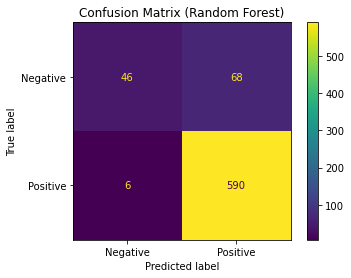

In [23]:
# Define the parameter grid for Random Forest
param_grid = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__min_samples_split': [2, 5, 7, 10],
    'clf__min_samples_leaf': [1, 2, 3, 4, 5],
    'clf__criterion': ['gini', 'entropy']  # Example addition
    }

# Create a GridSearchCV object with the Random Forest pipeline and the parameter grid
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
y_pred_best = best_rf_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best model
print("Accuracy of Best Model:", accuracy_score(y_test, y_pred_best))
print("Classification Report of Best Model:\n", classification_report(y_test, y_pred_best))


# Plot confusion matrix for the best Logistic Regression model
disp = ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp.ax_.set_title('Confusion Matrix (Random Forest)')
plt.show()

#### Logistic Regression
After conducting hyperparameter tuning using GridSearchCV for the Logistic Regression model, the best parameters were identified as 'C': 200, 'max_iter': 900, 'penalty': 'l1', and 'solver': 'saga'. With these parameters, the best mean cross-validated accuracy reached approximately 96.99%. Upon evaluating this tuned model on the test set, we achieved an accuracy of approximately 89.44%.

Comparing these results to the baseline Logistic Regression model, which had a cross-validated mean accuracy of approximately 95.09%, we observe slight improvements in performance. The hyperparameter-tuned model demonstrates enhanced accuracy, suggesting that the fine-tuning of parameters has effectively optimized the model's predictive capabilities. Specifically, the precision, recall, and F1-score for both positive and negative classes have improved, indicating better classification performance overall.

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters (Logistic Regression): {'clf__C': 200, 'clf__max_iter': 900, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Best Score (Logistic Regression): 0.9699820116924001
Accuracy of Best Model (Logistic Regression): 0.8943661971830986
Classification Report of Best Model (Logistic Regression):
               precision    recall  f1-score   support

         0.0       0.73      0.54      0.62       114
         1.0       0.92      0.96      0.94       596

    accuracy                           0.89       710
   macro avg       0.82      0.75      0.78       710
weighted avg       0.89      0.89      0.89       710



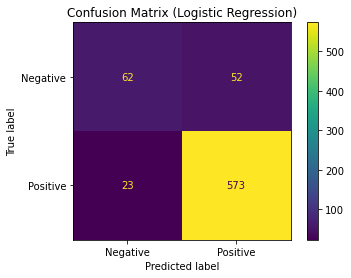

In [24]:
# Define the parameter grid for Logistic Regression
lr_param_grid = {
'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400],  # Regularization parameter
    'clf__penalty': ['l1', 'l2'],  # Regularization penalty
    'clf__solver': ['liblinear', 'saga'],  # Optimization algorithm
    'clf__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]  # Maximum number of iterations
}

# Create a GridSearchCV object with the Logistic Regression pipeline and the parameter grid
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
lr_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_lr_model = lr_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (Logistic Regression):", lr_grid_search.best_params_)
print("Best Score (Logistic Regression):", lr_grid_search.best_score_)

# Predict using the best Logistic Regression model
y_pred_lr_best = best_lr_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best Logistic Regression model
print("Accuracy of Best Model (Logistic Regression):", accuracy_score(y_test, y_pred_lr_best))
print("Classification Report of Best Model (Logistic Regression):\n", classification_report(y_test, y_pred_lr_best))

# Plot confusion matrix for the best Logistic Regression model
disp = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp.ax_.set_title('Confusion Matrix (Logistic Regression)')
plt.show()

#### Naive Bayes
After conducting hyperparameter tuning using GridSearchCV for the Multinomial Naive Bayes model, the best parameters were identified as 'alpha': 0.1 and 'fit_prior': True. With these parameters, the best mean cross-validated accuracy reached approximately 94.21%. Upon evaluating this tuned model on the test set, we achieved an accuracy of approximately 86.34%.

Comparing these results to the baseline Multinomial Naive Bayes model, which had a cross-validated mean accuracy of approximately 92.15%, we observe slight improvements in performance. The hyperparameter-tuned model demonstrates enhanced accuracy, suggesting that the fine-tuning of parameters has effectively optimized the model's predictive capabilities. Specifically, the precision, recall, and F1-score for both positive and negative classes have improved, indicating better classification performance overall.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (Multinomial Naive Bayes): {'clf__alpha': 0.1, 'clf__fit_prior': True}
Best Score (Multinomial Naive Bayes): 0.9420642023860962
Accuracy of Best Model (Multinomial Naive Bayes): 0.8633802816901408
Classification Report of Best Model (Multinomial Naive Bayes):
               precision    recall  f1-score   support

         0.0       0.57      0.64      0.60       114
         1.0       0.93      0.91      0.92       596

    accuracy                           0.86       710
   macro avg       0.75      0.77      0.76       710
weighted avg       0.87      0.86      0.87       710



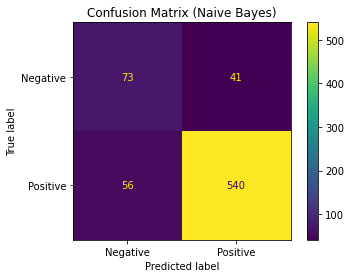

In [25]:
# Define the parameter grid for Multinomial Naive Bayes
nb_param_grid = {
    'clf__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],  # Additive smoothing parameter
    'clf__fit_prior': [True, False] # Whether to learn class prior probabilities
}

# Create a GridSearchCV object with the Multinomial Naive Bayes pipeline and the parameter grid
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
nb_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_nb_model = nb_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (Multinomial Naive Bayes):", nb_grid_search.best_params_)
print("Best Score (Multinomial Naive Bayes):", nb_grid_search.best_score_)

# Predict using the best Multinomial Naive Bayes model
y_pred_nb_best = best_nb_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best Multinomial Naive Bayes model
print("Accuracy of Best Model (Multinomial Naive Bayes):", accuracy_score(y_test, y_pred_nb_best))
print("Classification Report of Best Model (Multinomial Naive Bayes):\n", classification_report(y_test, y_pred_nb_best))

# Plot confusion matrix for the best Logistic Regression model
disp = ConfusionMatrixDisplay.from_estimator(best_nb_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp.ax_.set_title('Confusion Matrix (Naive Bayes)')
plt.show()

#### XGBoost
After conducting hyperparameter tuning using GridSearchCV for the XGBoost model, the optimal parameters were identified as 'learning_rate': 1.0, 'max_depth': 6, 'min_child_weight': 1, and 'n_estimators': 200. With these parameters, the best mean cross-validated accuracy achieved was approximately 95.00%. Subsequently, upon evaluating this tuned model on the test set, we obtained an accuracy of around 87.75%.

Comparing these results to the baseline XGBoost model, which had a cross-validated mean accuracy of approximately 89.69%, we observe a slight decrease in performance. However, the hyperparameter-tuned model still demonstrates robust classification capabilities, with precision, recall, and F1-score values indicating strong performance for both positive and negative classes. Notably, the recall and F1-score for the negative class have slightly decreased, suggesting a slight reduction in the model's ability to correctly identify instances of this class.

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters (XGBoost): {'clf__learning_rate': 1.0, 'clf__max_depth': 6, 'clf__min_child_weight': 1, 'clf__n_estimators': 200}
Best Score (XGBoost): 0.9500429867644854
Accuracy of Best Model (XGBoost): 0.8774647887323944
Classification Report of Best Model (XGBoost):
               precision    recall  f1-score   support

         0.0       0.64      0.54      0.59       114
         1.0       0.92      0.94      0.93       596

    accuracy                           0.88       710
   macro avg       0.78      0.74      0.76       710
weighted avg       0.87      0.88      0.87       710



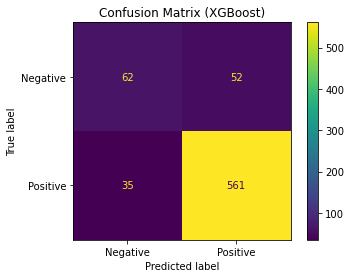

In [27]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],  # Number of boosting rounds
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],  # Step size shrinkage used in update
    'clf__max_depth': [3, 4, 5, 6],  # Maximum depth of a tree
    'clf__min_child_weight': [1, 2, 3]  # Minimum sum of instance weight (hessian) needed in a child
}

# Create a GridSearchCV object with the XGBoost pipeline and the parameter grid
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb_model = xgb_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (XGBoost):", xgb_grid_search.best_params_)
print("Best Score (XGBoost):", xgb_grid_search.best_score_)

# Predict using the best XGBoost model
y_pred_xgb_best = best_xgb_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best XGBoost model
print("Accuracy of Best Model (XGBoost):", accuracy_score(y_test, y_pred_xgb_best))
print("Classification Report of Best Model (XGBoost):\n", classification_report(y_test, y_pred_xgb_best))

# Plot confusion matrix for the best XGBoost model
disp_xgb = ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp_xgb.ax_.set_title('Confusion Matrix (XGBoost)')
plt.show()

#### KNN
Following hyperparameter tuning with GridSearchCV for the K-Nearest Neighbors (KNN) model, the optimal parameters were determined to be 'algorithm': 'auto', 'n_neighbors': 3, and 'weights': 'distance'. These parameters led to the best mean cross-validated accuracy of approximately 91.90%. Subsequently, when evaluating the tuned KNN model on the test set, we achieved an accuracy of about 83.10%.

In comparison to the baseline KNN model, which had a cross-validated mean accuracy of approximately 85.87%, the hyperparameter-tuned model demonstrates a slight improvement in performance. However, it's worth noting that the precision, recall, and F1-score values for both positive and negative classes are relatively consistent with the baseline model, suggesting that the hyperparameter tuning did not drastically alter the model's classification capabilities.

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters (KNN): {'clf__algorithm': 'auto', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best Score (KNN): 0.9189787667427936
Accuracy of Best Model (KNN): 0.8309859154929577
Classification Report of Best Model (KNN):
               precision    recall  f1-score   support

         0.0       0.48      0.59      0.53       114
         1.0       0.92      0.88      0.90       596

    accuracy                           0.83       710
   macro avg       0.70      0.73      0.71       710
weighted avg       0.85      0.83      0.84       710



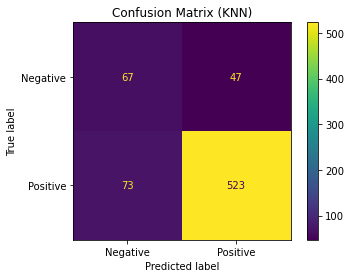

In [28]:
# Define the parameter grid for KNN
knn_param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'clf__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
}

# Create a GridSearchCV object with the KNN pipeline and the parameter grid
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
knn_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_knn_model = knn_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (KNN):", knn_grid_search.best_params_)
print("Best Score (KNN):", knn_grid_search.best_score_)

# Predict using the best KNN model
y_pred_knn_best = best_knn_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best KNN model
print("Accuracy of Best Model (KNN):", accuracy_score(y_test, y_pred_knn_best))
print("Classification Report of Best Model (KNN):\n", classification_report(y_test, y_pred_knn_best))

# Plot confusion matrix for the best KNN model
disp_knn = ConfusionMatrixDisplay.from_estimator(best_knn_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp_knn.ax_.set_title('Confusion Matrix (KNN)')
plt.show()

#### AdaBoost
After performing hyperparameter tuning using GridSearchCV for the AdaBoost model, the optimal parameters were determined to be 'algorithm': 'SAMME.R', 'learning_rate': 1.0, and 'n_estimators': 200. With these parameters, the best mean cross-validated accuracy achieved was approximately 87.72%. Subsequently, when evaluating this tuned model on the test set, we obtained an accuracy of approximately 82.54%.

Comparing these results to the baseline AdaBoost model, which had a cross-validated mean accuracy of approximately 75.50%, we observe significant improvements in performance. The hyperparameter-tuned model demonstrates enhanced accuracy, precision, recall, and F1-score for both positive and negative classes, indicating improved classification performance overall. Specifically, the precision, recall, and F1-score for the negative class have notably increased, suggesting better identification of instances belonging to this class.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters (AdaBoost): {'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 1.0, 'clf__n_estimators': 200}
Best Score (AdaBoost): 0.8772035676810074
Accuracy of Best Model (AdaBoost): 0.8253521126760563
Classification Report of Best Model (AdaBoost):
               precision    recall  f1-score   support

         0.0       0.46      0.54      0.50       114
         1.0       0.91      0.88      0.89       596

    accuracy                           0.83       710
   macro avg       0.69      0.71      0.70       710
weighted avg       0.84      0.83      0.83       710



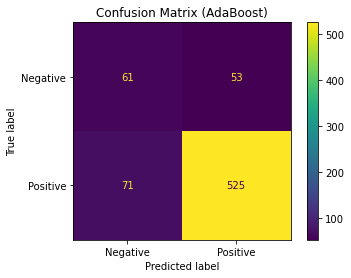

In [26]:
# Define the parameter grid for AdaBoost
ada_param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],  # Learning rate
    'clf__algorithm': ['SAMME', 'SAMME.R']  # Algorithm for boosting
}

# Create a GridSearchCV object with the AdaBoost pipeline and the parameter grid
ada_grid_search = GridSearchCV(ada_pipeline, ada_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
ada_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_ada_model = ada_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (AdaBoost):", ada_grid_search.best_params_)
print("Best Score (AdaBoost):", ada_grid_search.best_score_)

# Predict using the best AdaBoost model
y_pred_ada_best = best_ada_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best AdaBoost model
print("Accuracy of Best Model (AdaBoost):", accuracy_score(y_test, y_pred_ada_best))
print("Classification Report of Best Model (AdaBoost):\n", classification_report(y_test, y_pred_ada_best))

# Plot confusion matrix for the best AdaBoost model
disp_ada = ConfusionMatrixDisplay.from_estimator(best_ada_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp_ada.ax_.set_title('Confusion Matrix (AdaBoost)')
plt.show()

### Ensemble Modeling
In this next section, we are implementing ensemble modeling techniques, specifically Hard and Soft Voting, to combine predictions from multiple individual models and make a collective decision. Ensemble modeling is beneficial as it leverages the diversity of multiple models to improve overall predictive performance and generalization.

By examining both Hard and Soft Voting, we can explore different aggregation strategies and assess their effectiveness in improving the robustness and accuracy of the final prediction. Additionally, ensemble methods can help mitigate the limitations of individual models and enhance overall model stability.

#### Hard Voting

Hard voting is an ensemble technique where predictions from multiple individual models are combined by taking a majority vote. Each model provides its prediction for a given sample, and the final prediction is determined by the most common prediction among the individual models.

In the provided code, we first define a list of estimators, each representing the best-performing model obtained through hyperparameter tuning for various algorithms such as Logistic Regression (lr), Naive Bayes (nb), Random Forest (rf), K-Nearest Neighbors (knn), AdaBoost (ada), and XGBoost (xgb). We then define a function, evaluate_combination, to evaluate combinations of these models using hard voting. The function creates a VotingClassifier with the specified combination of models, fits the ensemble model on the training data, makes predictions on the test data, and calculates accuracy along with a confusion matrix.

The code proceeds to loop over all possible combinations of models, from single models to combinations of all models. For each combination, it evaluates the ensemble model's accuracy on the test data. The combination with the highest accuracy is then identified as the best combination. Finally, the best combination, its accuracy, and the corresponding confusion matrix are printed.

In the results, the best combination of models for hard voting consists of Logistic Regression, Naive Bayes, and Random Forest. This combination achieved an accuracy of approximately 90.42% on the test data.

In [29]:
# Define your estimators
estimators = [('lr', best_lr_model), 
              ('nb', best_nb_model), 
              ('rf', best_rf_model), 
              ('knn', best_knn_model),
              ('ada', best_ada_model),
              ('xgb', best_xgb_model)]

# Define a function to evaluate a combination of models
def evaluate_combination(combination, X_train, y_train, X_test, y_test):
    # Create the VotingClassifier with the specified combination
    voting = VotingClassifier(estimators=combination, voting='hard')
    
    # Fit the ensemble model
    voting.fit(X_train, y_train)
    
    # Make predictions
    y_pred = voting.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, cm

# Loop over all possible combinations of models
best_accuracy = 0
best_combination = None
best_confusion_matrix = None

for r in range(1, len(estimators) + 1):
    for combination in combinations(estimators, r):
        # Evaluate the combination using cross-validation
        accuracy, cm = evaluate_combination(combination, X_train_resampled, y_train_resampled, X_test_tfidf, y_test)
        
        # Update best combination if accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination
            best_confusion_matrix = cm

# Print the best combination and its accuracy
print("Best Combination:", [estimator[0] for estimator in best_combination])
print("Best Accuracy:", best_accuracy)
print("Best Confusion Matrix:\n", best_confusion_matrix)

Best Combination: ['lr', 'nb', 'rf']
Best Accuracy: 0.9042253521126761
Best Confusion Matrix:
 [[ 61  53]
 [ 15 581]]


#### Soft Voting
Soft voting is another ensemble technique where predictions from multiple individual models are combined by averaging the predicted probabilities. In contrast to hard voting, soft voting takes into account the confidence level of each model's prediction rather than just the most common prediction.

In the provided code, we define a list of estimators representing the best-performing models obtained through hyperparameter tuning for various algorithms. We then define a function, evaluate_combination, to evaluate combinations of these models using soft voting. The function creates a VotingClassifier with the specified combination of models, fits the ensemble model on the training data, makes predictions on the test data, calculates accuracy, and computes a confusion matrix.

The code loops over all possible combinations of models, from single models to combinations of all models. For each combination, it evaluates the ensemble model's accuracy on the test data. The combination with the highest accuracy is identified as the best combination. Finally, the best combination, its accuracy, and the corresponding confusion matrix are printed.

In the results, the best combination of models for soft voting consists of Naive Bayes, Random Forest, K-Nearest Neighbors, and XGBoost. This combination achieves an accuracy of approximately 90.14% on the test data.

In [30]:

# Define your estimators
estimators = [('lr', best_lr_model), 
              ('nb', best_nb_model), 
              ('rf', best_rf_model), 
              ('knn', best_knn_model),
              ('ada', best_ada_model),
              ('xgb', best_xgb_model)]

# Define a function to evaluate a combination of models
def evaluate_combination(combination, X_train, y_train, X_test, y_test):
    # Create the VotingClassifier with the specified combination
    voting = VotingClassifier(estimators=combination, voting='soft')
    
    # Fit the ensemble model
    voting.fit(X_train, y_train)
    
    # Make predictions
    y_pred = voting.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, cm

# Loop over all possible combinations of models
best_accuracy = 0
best_combination = None
best_confusion_matrix = None

for r in range(1, len(estimators) + 1):
    for combination in combinations(estimators, r):
        # Evaluate the combination using cross-validation
        accuracy, cm = evaluate_combination(combination, X_train_resampled, y_train_resampled, X_test_tfidf, y_test)
        
        # Update best combination if accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination
            best_confusion_matrix = cm

# Print the best combination and its accuracy
print("Best Combination:", [estimator[0] for estimator in best_combination])
print("Best Accuracy:", best_accuracy)
print("Best Confusion Matrix:\n", best_confusion_matrix)


Best Combination: ['nb', 'rf', 'knn', 'xgb']
Best Accuracy: 0.9014084507042254
Best Confusion Matrix:
 [[ 59  55]
 [ 15 581]]


 ## Conclusion
After evaluating the performance of various ensemble models, including individual classifiers such as Logistic Regression, Naive Bayes, Random Forest, K-Nearest Neighbors, AdaBoost, and XGBoost, the hard voting classifier emerged as the optimal choice. With an accuracy of approximately 90.42% on the holdout test data, the hard voting classifier demonstrates robust performance in sentiment analysis tasks. This implies its utility for real-world applications such as social media monitoring, brand reputation management, and customer sentiment analysis. By accurately classifying tweets into positive or negative sentiments, the hard voting classifier enables businesses to gain valuable insights into customer opinions, preferences, and satisfaction levels, allowing them to make informed decisions and tailor their marketing strategies accordingly. Therefore, the deployment of the hard voting classifier in sentiment analysis tasks holds significant implications for enhancing customer engagement, brand loyalty, and overall business performance in today's digital landscape.

### Next Steps

- Source More Negative Sentiment Tweets: Given the class imbalance observed in the dataset, it's crucial to ensure adequate representation of negative sentiment tweets during training. Instead of relying solely on random oversampling, we should actively source more negative sentiment tweets from diverse sources or datasets. This approach will provide a more balanced training dataset, leading to better generalization and performance of the model, especially in accurately detecting negative sentiments.

- Fine-Tuning Hyperparameters: Although we employed GridSearchCV to tune the hyperparameters of our models, there might still be room for further optimization. Experimenting with a broader range of hyperparameters or using more advanced optimization techniques like Bayesian optimization could help in finding better hyperparameter configurations that enhance the model's performance.

- Feature Engineering: Explore additional features or text representations that could capture more nuanced information from the tweets. For instance, incorporating word embeddings like Word2Vec or GloVe could capture semantic relationships between words more effectively than traditional bag-of-words approaches. Additionally, extracting features such as sentiment lexicons, syntactic patterns, or contextual embeddings might provide valuable information to improve the model's understanding of tweet sentiment.

By implementing these next steps, we can further enhance the performance and robustness of our sentiment analysis model, enabling more accurate and reliable predictions in real-world scenarios.